<a href="https://colab.research.google.com/github/smacawi/bert-topics/blob/main/bert_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

To make sure your colab doesn't disconnect due to inactivity, you can paste this code in the console of this tab (*right mouse click -> inspect -> Console tab and insert code*).

```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
```

### Requirements

In [ ]:
# for topic models
!pip install -U gensim
!pip install pyLDAvis
!pip install biterm

     |████████████████████████████████| 23.9MB 130kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7MB 19.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 49.5MB/s 
     |████████████████████████████████| 15.3MB 142kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=6ad62875676a9078660f080760db71786dbc0fc0c692700b26b91709a4cb6252
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'

     |████████████████████████████████| 81kB 8.1MB/s 
  Created wheel for biterm: filename=biterm-0.1.5-cp37-cp37m-linux_x86_64.whl size=195853 sha256=f8fcc723e54bf16a42975924eb097dcea22c63c459f4edb790014df83604f0d2
  Stored in directory: /root/.cache/pip/wheels/86/04/10/231fb1d39d86ab58c2683fd3d4fe8415a5bc284ba8a20fd638
Successfully built biterm


In [ ]:
# !pip install sentence_transformers==0.2.5.1
!pip install transformers==2.3.0

     |████████████████████████████████| 450kB 21.3MB/s 
     |████████████████████████████████| 133kB 54.2MB/s 
     |████████████████████████████████| 901kB 53.4MB/s 
     |████████████████████████████████| 1.2MB 56.9MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 7.4MB 50.1MB/s 
ERROR: botocore 1.20.54 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


### Imports

In [ ]:
import pandas as pd
import numpy as np
import itertools
import random
from pathlib import Path
import json
import time
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import re
import math

In [ ]:
# clustering / topic model modules
from sklearn.cluster import KMeans
from collections import Counter
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob, Word
import time

In [ ]:
# neural network modules
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import (BertTokenizer, BertModel, BertPreTrainedModel, AdamW,
                          get_linear_schedule_with_warmup,
                          )

In [ ]:
# lda modules
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pyLDAvis
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


In [ ]:
# btm modules
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms, topic_summuary
from biterm.btm import oBTM

In [ ]:
# coherence modules

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# data downloading
import requests
from zipfile import ZipFile

In [ ]:
# types
from typing import List, Tuple, Dict

In [ ]:
# plots
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap
from IPython.display import Image

## Download data

### Winter Storm Jacob 2020

In [ ]:
nlwx_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1wYsKTuKabfS7wrVYJ1yu9Sk0cHF7BDhN')

In [ ]:
#nlwx_df.head()

### CrisisNLP
Dowload CrisisNLP tweets (annotated by paid workers on crowdflower). 

For more information on dataset see: https://crisisnlp.qcri.org/lrec2016/lrec2016.html

In [ ]:
# download already filtered/split datasets
CRISIS_NLP_URL = 'https://drive.google.com/uc?export=download&id=1a5eWNUBKYb-RYQ9THU_GLRX2EaBh5spK'
DATA_PATH = Path.cwd()
CRISIS_NLP_PATH = DATA_PATH / "LREC_2016_datasets.zip"

r = requests.get(CRISIS_NLP_URL)
with CRISIS_NLP_PATH.open("wb") as f:
    f.write(r.content)

with ZipFile(CRISIS_NLP_PATH) as z:
    z.extractall(DATA_PATH)

In [ ]:
# download and split original data from CrisisNLP (might be rate-limited)
DOWNLOAD_ORIGINAL = False 

if DOWNLOAD_ORIGINAL:
    DATA_PATH = Path.cwd()
    CRISIS_NLP_PATH = DATA_PATH / "LREC_2016_datasets.zip"

    CRISIS_NLP_URL = "https://crisisnlp.qcri.org/data/lrec2016/labeled_cf/CrisisNLP_labeled_data_crowdflower.zip"
    CRISIS_NLP_DIR = "CrisisNLP_labeled_data_crowdflower"
    label_col = "choose_one_category"

    r = requests.get(CRISIS_NLP_URL)

    with CRISIS_NLP_PATH.open("wb") as f:
        f.write(r.content)

    with ZipFile(CRISIS_NLP_PATH) as z:
        z.extractall(DATA_PATH)

    for zip_file in (DATA_PATH / CRISIS_NLP_DIR).glob("*/*.zip"):
        print(f"unzipping {zip_file}")
        with ZipFile(zip_file) as z:
            z.extractall(zip_file.parent)


    def create_train_test_split(csv_path: Path, label_col, split: float = 0.8):
        df = pd.read_csv(csv_path, encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)
        train_df = pd.DataFrame(columns=df.columns)
        test_df = pd.DataFrame(columns=df.columns)
        train_path = csv_path.parent / f"{csv_path.stem}_train.csv"
        test_path = csv_path.parent / f"{csv_path.stem}_test.csv"
        for label in df[label_col].unique():
            label_df = df.loc[df[label_col] == label]
            train_df = train_df.append(label_df[:int(len(label_df)*split)])
            test_df = test_df.append(label_df[int(len(label_df)*split):])

        print(f"Train set:\n{train_df[label_col].value_counts()}")
        print(f"Test set:\n{test_df[label_col].value_counts()}")
        print("-"*80)
        train_df.to_csv(train_path)
        test_df.to_csv(test_path)


    split = 0.8
    for csv_path in (DATA_PATH / CRISIS_NLP_DIR).glob("*/*.csv"):
        if "train" in str(csv_path) or "test" in str(csv_path):
            continue
        else:
            print(f"Splitting: {csv_path.parent}")
            create_train_test_split(csv_path, label_col, split)

## FTE Model

### Finetune model

In [ ]:
# skip finetuning and load pre-finetuned model
FINETUNE = False

# Dataloader
BSZ = 8

# Optimizer
LR = 2e-5
EPS = 1e-8 

# Training
N_EPOCHS = 2 # Model converges within 2 epochs

# Random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#### Create dataloaders

In [ ]:
if FINETUNE:
  # read data
  DATA_PATH = Path.cwd() / "CrisisNLP_labeled_data_crowdflower"
  PATHS = ["2014_California_Earthquake", "2014_Chile_Earthquake_en", 
          "2013_Pakistan_eq", "2014_Hurricane_Odile_Mexico_en",
          "2014_India_floods", "2014_Pakistan_floods", 
          "2014_Philippines_Typhoon_Hagupit_en","2015_Cyclone_Pam_en",
          "2015_Nepal_Earthquake_en"]

  def read_data(
          data_dir: Path, 
          events: List[str], 
          train_test: str, 
          text_col: str = "tweet_text", 
          label_col: str = "choose_one_category"
          ) -> List[Tuple[str, str]]:
      data = []
      for event in events:
          csv_paths = list((data_dir / event).glob(f"*_{train_test}.csv"))
          assert len(csv_paths) == 1, f"Found files:{csv_paths}\n for event {event}"

          df = pd.read_csv(csv_paths[0], encoding = "ISO-8859-1")
          data.extend(list(zip(df[text_col], df[label_col])))
      return(data)

  data_train = read_data(DATA_PATH, PATHS, "train")
  data_val = read_data(DATA_PATH, PATHS, "test")

  # Note: there seems to be issues with the encoding of the CrisisNLP data
  print(f"Training data: {len(data_train)} examples; e.g. {data_train[0]}")
  print(f"Validation data: {len(data_val)} examples; e.g. {data_val[0]}")

In [ ]:
if FINETUNE:
  # create data loader
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

  train_labels = [tpl[1] for tpl in data_train]
  val_labels = [tpl[1] for tpl in data_val]
  ltoi = {l: i for i,l in enumerate(set(train_labels + val_labels))}

  def create_dataloader(
          data: List[Tuple[str, str]],
          tokenizer: BertTokenizer,
          ltoi: Dict[str, int],
          batch_size: int
          ):
      texts_raw = [tpl[0] for tpl in data]
      d = tokenizer.batch_encode_plus(
          texts_raw, add_special_tokens=True, return_tensors='pt',
      )
      labels = [tpl[1] for tpl in data]
      labels = torch.LongTensor([ltoi[l] for l in labels])

      ds = TensorDataset(d['input_ids'], d['attention_mask'], labels)
      sampler = RandomSampler(ds)
      dataloader = DataLoader(ds, sampler=sampler, batch_size=batch_size)
      return(dataloader)

  train_dataloader = create_dataloader(data_train, tokenizer, ltoi, BSZ)
  val_dataloader = create_dataloader(data_val, tokenizer, ltoi, BSZ)

#### Initialize model

In [ ]:
class BertForSequenceClassificationOutputPooled(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        outputs = (logits,) + outputs[2:] # add hidden states and attention if they are here
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))
            outputs = (loss,) + outputs
        
        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
if FINETUNE:

  model = BertForSequenceClassificationOutputPooled.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = len(ltoi), # The number of output labels.
      output_attentions = True, # Whether the model returns attentions weights.
      output_hidden_states = True, # Whether the model returns all hidden-states.
  ).to(device)

  optimizer = AdamW(model.parameters(), lr=LR, eps=EPS)
  total_steps = len(train_dataloader) * N_EPOCHS
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

#### Train model

In [ ]:
if FINETUNE:
  
  def flat_accuracy(preds: np.ndarray, labels: np.ndarray):
      pred_flat = np.argmax(preds, axis=1).flatten()
      labels_flat = labels.flatten()
      return np.sum(pred_flat == labels_flat) / len(labels_flat)
      
  def format_time(seconds: int):
      # Format time as hh:mm:ss
      seconds = int(round((seconds))) 
      return str(datetime.timedelta(seconds=seconds))

In [ ]:
if FINETUNE:
  
  torch.cuda.empty_cache()

  loss_values = []
  for epoch_i in range(N_EPOCHS):
      print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, N_EPOCHS))
      print('Training...')
      model.train()
      total_loss = 0

      t0 = time.time()
      pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
      for step, batch in pbar:
          b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

          model.zero_grad()        
          outputs = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)

          loss = outputs[0]
          total_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          
          optimizer.step()
          scheduler.step()

          logits = outputs[1].detach().cpu().numpy()
          label_ids = b_labels.cpu().numpy()
          acc = flat_accuracy(logits, label_ids)
          pbar.set_description(f"Acc: {acc}")

      avg_train_loss = total_loss / len(train_dataloader)            
      loss_values.append(avg_train_loss)
      print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


      print("\nRunning Validation...")
      model.eval()
      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0
      
      t0 = time.time()
      for batch in val_dataloader:
          b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

          with torch.no_grad():  
              outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)

          logits = outputs[0]

          logits = logits.cpu().numpy()
          label_ids = b_labels.cpu().numpy()
          tmp_eval_accuracy = flat_accuracy(logits, label_ids)
          eval_accuracy += tmp_eval_accuracy
          nb_eval_steps += 1

      print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

      print("")
      print("Training complete!")

#### Save model

In [ ]:
if FINETUNE:
  
  OUT_PATH = Path.cwd() / "model"
  OUT_PATH.mkdir(parents=True)
  model.save_pretrained(OUT_PATH)
  tokenizer.save_pretrained(OUT_PATH)

### Embed tweets

#### Initialize model

In [ ]:
class BertForClustering(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
        output, pooled, hidden, attention = outputs

        pad_mask = (input_ids != self.config.pad_token_id).unsqueeze(-1)
        mean_pooled = (output * pad_mask).sum(axis=1) / pad_mask.sum(axis=1)
        
        # attention shape: (layer, bsz, head, token, attention)
        # want attention of CLS token (in position 0) from last layer
        # averaged over heads and normalized
        cls_attn = attention[-1][:,:,0,:].mean(axis=1)
        cls_attn = cls_attn / cls_attn.sum(axis=1).unsqueeze(-1)

        return mean_pooled, cls_attn

In [ ]:
# helper method to get word-level attentions from token-level
def get_word_level_attns(
        input_ids: torch.LongTensor, 
        cls_attn: torch.FloatTensor, 
        ids_to_tokens: Dict[int, str],
        ) -> Tuple[List[str], List[float]]:
    batch_words = []
    batch_attn_scores = []
    num_subwords = 1
    for i, (iids, attns) in enumerate(zip(input_ids, cls_attn)):
        batch_words += [[]]
        batch_attn_scores += [[]]
        for iid, attn in zip(iids, attns):
            token = ids_to_tokens[iid.item()]
            if token in ['[CLS]', '[SEP]', '[PAD]']:
                continue
            if token.startswith("##"):
                batch_words[i][-1] += token[2:]
                batch_attn_scores[i][-1] += attn.item()
                num_subwords += 1
            else:
                # average score of previous word (if it exists)
                if len(batch_attn_scores[i]):
                    batch_attn_scores[i][-1] /= num_subwords
                    num_subwords = 1
                # start new word
                batch_words[i] += [token]
                batch_attn_scores[i] += [attn.item()]
    return batch_words, batch_attn_scores

In [ ]:
if FINETUNE:
  MODEL_PATH = Path.cwd() / "model"
else:
  if not Path("model_save_attention_1epoch").exists():
    !gdown --id 1jnQVZpdsFIAbV8J7szUjtfQ0uXo_NOh_
    !unzip model_save_attention_1epoch.zip
  MODEL_PATH = Path.cwd() / "model_save_attention_1epoch"


model = BertForClustering.from_pretrained(MODEL_PATH).to(device).eval()
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH, do_lower_case=True)
model.config.pad_token_id = tokenizer.pad_token_id

Downloading...
From: https://drive.google.com/uc?id=1jnQVZpdsFIAbV8J7szUjtfQ0uXo_NOh_
To: /content/model_save_attention_1epoch.zip
446MB [00:05, 82.5MB/s]
Archive:  model_save_attention_1epoch.zip
   creating: model_save_attention_1epoch/
  inflating: model_save_attention_1epoch/special_tokens_map.json  
 extracting: model_save_attention_1epoch/tokenizer_config.json  
  inflating: model_save_attention_1epoch/pytorch_model.bin  
   creating: model_save_attention_1epoch/.ipynb_checkpoints/
  inflating: model_save_attention_1epoch/.ipynb_checkpoints/config-checkpoint.json  
  inflating: model_save_attention_1epoch/config.json  
  inflating: model_save_attention_1epoch/outputs.pkl  
 extracting: model_save_attention_1epoch/loss_values.pkl  
  inflating: model_save_attention_1epoch/vocab.txt  


In [ ]:
bert_baseline = BertForClustering.from_pretrained(
    'bert-base-uncased',output_attentions=True, output_hidden_states=True
    ).to(device).eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_baseline.config.pad_token_id = tokenizer.pad_token_id

#### Compute embeds and attentions

In [ ]:
input_ids = tokenizer.batch_encode_plus(nlwx_df.text, add_special_tokens=True, 
                                        return_tensors='pt')['input_ids']
print(f"Encoded {len(input_ids)} examples, with max length {input_ids.shape[-1]}")

Encoded 21797 examples, with max length 117


In [ ]:
EMBED_BSZ = 128
torch.cuda.empty_cache()

batch_embeds = []
batch_words = []
batch_word_attns = []
batch_embeds_bert = []
batch_words_bert = []
batch_word_attns_bert = []
for i in tqdm(list(range(0, len(input_ids), EMBED_BSZ))):
    batch = input_ids[i:i+EMBED_BSZ].to(device)
    with torch.no_grad():
        embeds, cls_attn = model(batch)
        words, attns = get_word_level_attns(batch, cls_attn, tokenizer.ids_to_tokens)
        embeds_bert, cls_attn_bert = bert_baseline(batch)
        words_bert, attns_bert = get_word_level_attns(batch, cls_attn_bert, tokenizer.ids_to_tokens)
    batch_embeds += [embeds.cpu().numpy()]
    batch_words += [words]
    batch_word_attns += [attns]
    batch_embeds_bert += [embeds_bert.cpu().numpy()]
    batch_words_bert += [words_bert]
    batch_word_attns_bert += [attns_bert]

# concatenate batches
batch_embeds = np.concatenate(batch_embeds)
batch_words = list(itertools.chain(*batch_words))
batch_word_attns = list(itertools.chain(*batch_word_attns))
batch_embeds_bert = np.concatenate(batch_embeds_bert)
batch_words_bert = list(itertools.chain(*batch_words_bert))
batch_word_attns_bert = list(itertools.chain(*batch_word_attns_bert))

### Cluster tweets

In [ ]:
def topics_df(topics, components, n_words = 20):
    df = {}
    for i in range(topics):
        words = sorted(components[i], key=components[i].get, reverse=True)[:n_words]
        df['topic %d' % (i)] = words
        if len(words) < n_words:
            df['topic %d' % (i)].extend([''] * (n_words - len(words)))
    return pd.DataFrame.from_dict(df)

def get_stopwords(hashtags = [], 
                  URL = 'https://drive.google.com/uc?export=download&id=1DcYzpMB-3Dbp7IEtmTbTd4DIgtz9ut6I'):
  r = requests.get(URL)
  stopwords = json.loads(r.text)
  stopwords.extend(['#', '@', '…', "'", "’", "[unk]", "\"", ";", 
                    "*", "_", "amp", "&", "“", "”"] + hashtags)
  return(stopwords)

stopwords_bert = get_stopwords()

In [ ]:
URL_RE = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'

class BertTopicModel():
    def __init__(self, texts, attentions, embeddings, n_clusters):
        self.texts = texts
        self.attentions = attentions
        self.embeddings = embeddings
        self.n_clusters = n_clusters
        self.filtered_a = []
        self.filtered_t = [] 
        self.filtered_l = []
        
    def get_clusters(self):
        print("Fitting kmeans model.")
        kmeans = KMeans(n_clusters = self.n_clusters, random_state = 0).fit(self.embeddings)
        self.labels = kmeans.labels_
        self._get_label_counts()
        return self.labels
    
    def get_features(self, stopwords, phrasing = False,min_count=5, threshold=100):
        self._filter_data(stopwords)
        if phrasing == True:
            self._get_phrases(min_count=min_count, threshold=threshold)
        else:
            self.features = self.filtered_t
        print(len(self.features))
        self._remove_ifreq_words()
        print(len(self.features))
        return self.features
        
    def _filter_data(self, stopwords):
        url_re = URL_RE
        print("Filtering attentions.")
        for idx, a in enumerate(self.attentions):
            f = [(i[0].lower(), i[1]) for i in a]
            f = [(Word(i[0]).lemmatize(), i[1]) 
                 for i in f if (i[0] not in stopwords) 
                 and (not re.match(url_re, i[0]))
                 and (i[0].find('snowmageddon2020') == -1)]
            f_txt = [re.sub('[^a-zA-Z]+', '', w[0]) for w in f]
            f = [(re.sub('[^a-zA-Z]+', '', w[0]), w[1]) for w in f]
            if len(f) > 1:
                self.filtered_a.append(f)
                self.filtered_t.append(f_txt)
                self.filtered_l.append(self.labels[idx])
                
    def determine_cluster_components(self, ngram):
        print("""
    Determining cluster components. This will take a while. 
    Progress will be printed for every 500th processed property.
        """)
        components = {}
        words_label = {}
        start_time = time.time()
        for idx, label in enumerate(self.filtered_l):
            if label not in components:
                components[label] = {}
                words_label[label] = []
            else:
                f = self._generate_ngram(self.filtered_a[idx], ngram)
                for w in f:
                    word = ' '.join([r[0] for r in w])
                    score = np.mean([r[1] for r in w])
                    if word in self.features[idx]:
                        if word in components[label]:
                            components[label][word] += score
                        else:
                            components[label][word] = score
                        words_label[label].append(word)
            if (idx + 1) % 5000 == 0:
                print(f'Processed {(idx + 1)} texts in {round(time.time() - start_time, 2)} seconds.')

        print(f"Finished determining a total of {idx + 1} cluster components.\
        Total time {round(time.time() - start_time, 2)} seconds.")
        self.components = components 
        self.words_label = words_label
        return self.components, self.words_label
    
    def get_tfidf_components(self, max_df = 1.0, stf = False):
        tfidf_indexed = self._tf_icf(max_df, stf)
        components_tfidf_attn = {}
        components_tfidf = {}
        for k1 in self.components:
            components_tfidf_attn[k1] = {}
            components_tfidf[k1] = {}
            for k2 in self.components[k1]:
                try:
                    components_tfidf_attn[k1][k2] = tfidf_indexed[k1][k2] * self.components[k1][k2]
                    components_tfidf[k1][k2] = tfidf_indexed[k1][k2]
                except:
                    continue
        self.components_tfidf = components_tfidf
        self.components_tfidf_attn = components_tfidf_attn
        return self.components_tfidf,self.components_tfidf_attn
    
    def reset_model(self):
        self.filtered_a = []
        self.filtered_t = [] 
        self.filtered_l = []
        self.components = [] 
        self.words_label = []
        self.features = []
        self.words_label = []
        self.components_tfidf = []
        self.components_tfidf_attn = []
    
    def _get_label_counts(self):
        unique, counts = np.unique(self.labels, return_counts=True)
        print("The number of texts per label are:")
        print(dict(zip(unique, counts)))
        
    # Generate phrases for topic cluster components using Gensim Phrases() and Phraser() functions:
    # https://radimrehurek.com/gensim/models/phrases.html
    def _get_phrases(self, min_count=5, threshold=100):
        bigram = Phrases(self.filtered_t, min_count=min_count, threshold = threshold) # higher threshold fewer phrases.
        trigram = Phrases(bigram[self.filtered_t])  

        # 'Phraser' is a wrapper that makes 'Phrases' run faster
        bigram_phraser = Phraser(bigram)
        trigram_phraser = Phraser(trigram)

        phrased_bi = [b for b in bigram[self.filtered_t]]
        phrased_tri = [t for t in trigram[[b for b in bigram[self.filtered_t]]]]
        self.features = [[w.replace('_', ' ') for w in sublist] for sublist in phrased_bi]
        
    def _remove_ifreq_words(self, vocab_threshold = 10):
        texts = [word for words in self.features for word in words]
        vocab = self._get_frequent_vocab(texts, threshold = vocab_threshold)
        updated_f = []
        for f in self.features:
            updated_f.append([word for word in f if word in vocab and len(word) > 0])
        self.features = updated_f
    
    def _get_frequent_vocab(self, corpus, threshold=10):
        '''
        Gets words whose frequency exceeds that of the threshold
        in a given corpus.
        :param corpus: list of tokenized words
        :param threshold:
        :return: list of words with higher frequency than threshold
        '''
        freq = Counter(corpus)
        filtered = [word for word, count in freq.items() if count >= threshold]
        return filtered
    
    def _generate_ngram(self, 
                        seq, 
                        ngram = (1, 3)):
        g = []
        for i in range(ngram[0], ngram[-1] + 1):
            g.extend(list(self._ngrams_generator(seq, i)))
        return g
    
    def _ngrams_generator(
        self,
        sequence,
        n,
        pad_left = False,
        pad_right = False,
        left_pad_symbol = None,
        right_pad_symbol = None):
        """
        generate ngrams.

        Parameters
        ----------
        sequence : list of str
            list of tokenize words.
        n : int
            ngram size

        Returns
        -------
        ngram: list
        """
        sequence = self._pad_sequence(
            sequence, n, pad_left, pad_right, left_pad_symbol, right_pad_symbol
        )

        history = []
        while n > 1:
            try:
                next_item = next(sequence)
            except StopIteration:
                return
            history.append(next_item)
            n -= 1
        for item in sequence:
            history.append(item)
            yield tuple(history)
            del history[0]
            
    # Pad sequence helper funtion for ngram generator.
    # Implemented from block 14 of commit 9895ee0 at:
    # https://github.com/huseinzol05/NLP-Models-Tensorflow/blob/master/topic-model/2.bert-topic.ipynb
    def _pad_sequence(
        self,
        sequence,
        n,
        pad_left = False,
        pad_right = False,
        left_pad_symbol = None,
        right_pad_symbol = None):
        
        sequence = iter(sequence)
        if pad_left:
            sequence = itertools.chain((left_pad_symbol,) * (n - 1), sequence)
        if pad_right:
            sequence = itertools.chain(sequence, (right_pad_symbol,) * (n - 1))
        return sequence
    
    def _tf_icf(self, max_df, stf):
        def dummy_fun(doc):
            return doc
        
        tfidf_vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=dummy_fun,
            preprocessor=dummy_fun,
            token_pattern=None,
            max_df = max_df,
            sublinear_tf = stf)

        tf_idf_corpus = [[item for item in self.words_label[key]] for key in range(self.n_clusters)]
        transformed = tfidf_vectorizer.fit_transform(tf_idf_corpus)
        index_value={i[1]:i[0] for i in tfidf_vectorizer.vocabulary_.items()}
        fully_indexed = []
        for row in transformed:
            fully_indexed.append({index_value[column]:value for (column,value) in zip(row.indices,row.data)})
        return(fully_indexed)
    

In [ ]:
class TopicSearch():
    def __init__(self,
                 embeddings = batch_embeds,
                 texts = batch_words,
                 attns = batch_word_attns,
                 stopwords=stopwords_bert):
        self.topics = {}
        self.embeddings = embeddings
        self.texts = texts
        self.attns = attns
        self.hyperparams = {}
        self.stopwords = stopwords

    def search(self,
               ngrams=[1,2], 
               max_df=[0.6, 0.7, 0.8, 0.85, 0.9, 1.0],
               stf=[True, False],
               n_topics=[5,10,15],
               hashtags=[],
               hashtag_opts=[True, False],
               phrasing=[True, False],
               p_min_count=5,
               p_threshold=100,
               embedding_name='fte'):

      e = embedding_name
      self.hyperparams[e] = {}
      for t in n_topics:
        self._init_model(t)
        self.hyperparams[e][t] = {}
        self.hyperparams[e][t]['hashtags'] = {}
        for h in hashtag_opts:
          self.hyperparams[e][t]['hashtags'][h] = {}
          self.hyperparams[e][t]['hashtags'][h]['ngram'] = {}
          for n in ngrams:
            ngram = (1, n)
            self.hyperparams[e][t]['hashtags'][h]['ngram'][n] = {}
            self.hyperparams[e][t]['hashtags'][h]['ngram'][n]['stf'] = {}
            for s in stf:
              self.hyperparams[e][t]['hashtags'][h]['ngram'][n]['stf'][s] = {}
              self.hyperparams[e][t]['hashtags'][h]['ngram'][n]['stf'][s]['max_df'] = {}
              for m in max_df:
                self.hyperparams[e][t]['hashtags'][h]['ngram'][n]['stf'][s]['max_df'][m] = {}
                self.hyperparams[e][t]['hashtags'][h]['ngram'][n]['stf'][s]['max_df'][m]['phrasing'] = {}
                for p in phrasing:
                  self.hyperparams[e][t]['hashtags'][h]['ngram'][n]['stf'][s]['max_df'][m]['phrasing'][p] = {}
                  features = self.bertTM.get_features(stopwords=self.stopwords,
                                                      phrasing=p,
                                                      min_count=p_min_count,
                                                      threshold=p_threshold)
                  print(f'Getting components for kmeans model for '
                        f'{t} topics, phrasing {p}, {n} ngrams, mdf {m} and stf {s}.')
                  components, words_label = self.bertTM.determine_cluster_components(ngram)
                  components_tfidf, components_tfidf_attn = self.bertTM.get_tfidf_components(max_df = m,
                                                                                            stf = s)
                  print(f'Determining topics for kmeans model with '
                        f'{t} topics, phrasing {p}, {n} ngrams, mdf {m} and stf {s}.')
                  self._store_hyperparams(e,t,h,s,m,p, n, features, 
                                          components, components_tfidf, components_tfidf_attn)
                  self.bertTM.reset_model()

    def _store_hyperparams(self,e,t,h,s,m,p, n, features, 
                           c, ctf, ctfa):
        self.hyperparams[e][t]['hashtags'][h]['ngram'][n]['stf'][s]['max_df'][m]['phrasing'][p]['features'] = features
        self.hyperparams[e][t]['hashtags'][h]['ngram'][n]['stf'][s]['max_df'][m]['phrasing'][p]['topics_attn'] = self._gen_topics(t, c)
        self.hyperparams[e][t]['hashtags'][h]['ngram'][n]['stf'][s]['max_df'][m]['phrasing'][p]['topics_tfidf'] = self._gen_topics(t, ctf)
        self.hyperparams[e][t]['hashtags'][h]['ngram'][n]['stf'][s]['max_df'][m]['phrasing'][p]['topics_tfidf_attn'] = self._gen_topics(t, ctfa)
    
    def _cluster_embeds(
        n_clusters: int
        ) -> Tuple[KMeans, np.ndarray]:
        kmeans = KMeans(n_clusters = N_CLUSTERS, random_state = 0)
        self.klabels = kmeans.fit_predict(self.embeddings)
        unique, counts = np.unique(kmeans.labels_, return_counts=True)
        print("The number of texts per label are:")
        print(dict(zip(unique, counts)))

    def _init_model(self, t):
        # Run kmeans model
        print(f"Running kmeans model with {t} topics.")
        self.bertTM = BertTopicModel(
            texts = self.texts, 
            attentions = self.attns, 
            embeddings = self.embeddings,
            n_clusters = t)
        self.labels = self.bertTM.get_clusters()
    
    def _gen_topics(self, t, components, n_words = 10):
        print(f"Determining topics for kmeans model for with {t} topics.")
        topics = topics_df(topics = t, components = components, n_words = n_words)
        return topics


In [ ]:
ngrams=[1]
max_df=[0.7, 0.8, 0.85]
stf=[True]
n_topics=[5,9,10,15]
hashtag_opts=[False]
phrasing=[False]
p_min_count=5
p_threshold=100
hashtags =  ['nlwhiteout', 'nlweather', 'newfoundland', 
             'nlblizzard2020', 'nlstm2020','snowmaggedon2020', 
             'stmageddon2020','stormageddon2020', 'newfoundland2020',
             'snowpocalypse2020','snowmageddon','nlstm', 
             'nlwx', 'nlwx2020','nlblizzard', 'nlstorm2020']

In [ ]:
batch_words_attn_pairs = [list(zip(batch_words[i], batch_word_attns[i])) for i in range(0, len(batch_words))] 

ts = TopicSearch(embeddings = batch_embeds,
                 texts = batch_words,
                 attns = batch_words_attn_pairs,
                 stopwords=stopwords_bert)
ts.search(ngrams=ngrams,
          max_df=max_df,
          stf=stf,
          n_topics = n_topics,
          hashtags = hashtags,
          hashtag_opts = hashtag_opts,
          phrasing = phrasing,
          p_min_count=5,
          p_threshold=100,
          embedding_name='fte')

Running kmeans model with 5 topics.
Fitting kmeans model.
The number of texts per label are:
{0: 9570, 1: 5693, 2: 857, 3: 2991, 4: 2686}
Filtering attentions.
21766
21766
Getting components for kmeans model for 5 topics, phrasing False, 1 ngrams, mdf 0.7 and stf True.

    Determining cluster components. This will take a while. 
    Progress will be printed for every 500th processed property.
        
Processed 5000 texts in 0.75 seconds.
Processed 10000 texts in 1.52 seconds.
Processed 15000 texts in 2.3 seconds.
Processed 20000 texts in 3.09 seconds.
Finished determining a total of 21766 cluster components.        Total time 3.35 seconds.
Determining topics for kmeans model with 5 topics, phrasing False, 1 ngrams, mdf 0.7 and stf True.
Determining topics for kmeans model for with 5 topics.
Determining topics for kmeans model for with 5 topics.
Determining topics for kmeans model for with 5 topics.
Filtering attentions.
21766
21766
Getting components for kmeans model for 5 topics, ph

## Baselines

In [ ]:
batch_words_attn_pairs_bert = [list(zip(batch_words_bert[i], batch_word_attns_bert[i])) for i in range(0, len(batch_words_bert))] 

ts_bert = TopicSearch(embeddings = batch_embeds_bert,
                 texts = batch_words_bert,
                 attns = batch_words_attn_pairs_bert,
                 stopwords=stopwords_bert)
ts_bert.search(ngrams=ngrams,
          max_df=max_df,
          stf=stf,
          n_topics = n_topics,
          hashtags = hashtags,
          hashtag_opts = hashtag_opts,
          phrasing = phrasing,
          p_min_count=5,
          p_threshold=100,
          embedding_name='bert')

Running kmeans model with 5 topics.
Fitting kmeans model.
The number of texts per label are:
{0: 1645, 1: 8056, 2: 6676, 3: 4054, 4: 1366}
Filtering attentions.
21766
21766
Getting components for kmeans model for 5 topics, phrasing False, 1 ngrams, mdf 0.7 and stf True.

    Determining cluster components. This will take a while. 
    Progress will be printed for every 500th processed property.
        
Processed 5000 texts in 0.75 seconds.
Processed 10000 texts in 1.5 seconds.
Processed 15000 texts in 2.28 seconds.
Processed 20000 texts in 3.06 seconds.
Finished determining a total of 21766 cluster components.        Total time 3.33 seconds.
Determining topics for kmeans model with 5 topics, phrasing False, 1 ngrams, mdf 0.7 and stf True.
Determining topics for kmeans model for with 5 topics.
Determining topics for kmeans model for with 5 topics.
Determining topics for kmeans model for with 5 topics.
Filtering attentions.
21766
21766
Getting components for kmeans model for 5 topics, p

In [ ]:
trainLDA = False
trainBTM = False

In [ ]:
if not (trainLDA or trainBTM):
  if not Path("lda_coherence").exists():
    !gdown --id 1WaB0v5qlBIhp0RIORO_fNiWNcoSwiC6w

  lda_df = pd.read_csv("lda_coherence.csv")

if not trainLDA:
  if not Path("lda_labels").exists():
    !gdown --id 14lk_2gTzPoaO6CfXcvSc93tWpOcJ-FE-

  lda_labels = pd.read_csv("lda_labels.csv")

if not trainBTM:
  if not Path("btm_labels").exists():
    !gdown --id 1gnudbXBS0mK_tq2ayxkn94XM31xrIqbT

  btm_labels = pd.read_csv("btm_labels.csv")

Downloading...
From: https://drive.google.com/uc?id=1WaB0v5qlBIhp0RIORO_fNiWNcoSwiC6w
To: /content/lda_coherence.csv
100% 441/441 [00:00<00:00, 205kB/s]
Downloading...
From: https://drive.google.com/uc?id=14lk_2gTzPoaO6CfXcvSc93tWpOcJ-FE-
To: /content/lda_labels.csv
2.46MB [00:00, 38.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gnudbXBS0mK_tq2ayxkn94XM31xrIqbT
To: /content/btm_labels.csv
2.46MB [00:00, 39.1MB/s]


### Preprocessing and Util

In [ ]:
if (trainLDA or trainBTM):

  def get_frequent_vocab(corpus, threshold=0):
      '''
      Gets words whose frequency exceeds that of the threshold
      in a given corpus.

      :param corpus: list of tokenized words
      :param threshold:
      :return: list of words with higher frequency than threshold
      '''
      vect = CountVectorizer().fit(corpus)
      bag_of_words = vect.transform(corpus)
      sum_words = bag_of_words.sum(axis=0)
      freq = {word: sum_words[0, idx] for word, idx in vect.vocabulary_.items()}
      return [word for word, count in freq.items() if count >= threshold]

  def preprocess(df,
                  extra_stopwords,
                  tweet_col='text',
                  to_lower = True,
                  include_bigram = False,
                  vocab_threshold = 10
                  ):
      '''
      Preprocesses text in a certain dataframe column.

      :param df: dataframe to be processed
      :param tweet_col: name of dataframe column containing text
      :param to_lower: flag whether to convert to lowercase
      :param include_bigram: flag whether to include bigrams
      :param vocab_threshold: minimum number of words in each tweet
      :param extra_stopwords: extra stopwords to add onto default nltk
      :return: original df with extra column, 'tokenized_[tweet_col]'
      '''
      df_copy = df.copy()

      # drop rows with empty values
      df_copy.dropna(how='all', inplace=True)
      # drop rows with identical text
      df_copy.drop_duplicates(subset = 'text', inplace = True)

      # lower the tweets
      if to_lower:
          df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
      else:
          df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str

      # filter out stop words and URLs
      en_stop_words = set(stopwords.words('english'))

      #extended stop words for twitter and extra stop words from user
      extended_stop_words = en_stop_words.union({
                                '&amp;', 'rt',
                                'th', 'co', 're', 've', 'kim', 'daca'
                            }).union(extra_stopwords)

      #removes urls
      url_re = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
      df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join(
          [word for word in row.split() if (word not in extended_stop_words) and (not re.match(url_re, word)) and (word.find('snowmageddon2020') == -1)]))

      # tokenize the tweets
      tokenizer = RegexpTokenizer(r'[a-zA-Z]\w+\'?\w*')
      df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))

      if include_bigram:
          # Build the bigram and trigram models
          texts = df_copy['tokenized_' + tweet_col].values.tolist()
          bigram = Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
          bigram_mod = Phraser(bigram)
          df_copy['tokenized_' + tweet_col] = pd.Series([bigram_mod[doc] for doc in texts])

      # remove terms with frequency less than 10
      if vocab_threshold > 0:
          texts = [word for tweet in df_copy.tokenized_text for word in tweet]
          vocab = get_frequent_vocab(texts, threshold = vocab_threshold)
          df_copy['tokenized_' + tweet_col] = df_copy['tokenized_' + tweet_col].apply(lambda row: [word for word in row if word in vocab])

      #remove tweets with length less than two
      df_copy = df_copy[df_copy['tokenized_' + tweet_col].map(len) >= 2]

      return df_copy


### LDA

#### Initialize Model

In [ ]:
if trainLDA:
  def build_lda_model(data, num_topics, include_vis = False):
      '''
      Trains LDA model using Gensim based on parameters
      and saves a pyLDAvis visualization of the topics.

      :param data: list of tweets to be processed
      :param num_topics: number of topics for the model
      :param include_vis: flag to include pyLDAvis
      :return: LDA model as given by Gensim
      '''
      # Create Dictionary
      id2word = corpora.Dictionary(data)

      # Create Corpus: Term Document Frequency
      corpus = [id2word.doc2bow(text) for text in data]

      # Build LDA model
      lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=num_topics,
                                                  random_state=100,
                                                  update_every=1,
                                                  chunksize=10,
                                                  passes=10,
                                                  alpha='symmetric',
                                                  iterations=100,
                                                  per_word_topics=True)

      #pyLDAvis
      if include_vis:
          p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
          pyLDAvis.save_html(p, 'lda_{}.html'.format(num_topics))

      return lda_model

#### Get Model Results

In [ ]:
if trainLDA:

  def top_vocab_lda (lda_model, num):
      '''
      Gets top vocabulary words for a given LDA model and saves to csv.

      :param lda_model: LDA model to be evaluated
      :param num: number of vocabulary words assigned to each topic
      :return: csv of top words per topic
      '''
      top_words_per_topic = []
      for t in range(lda_model.num_topics):
          top_words_per_topic.extend([(t,) + x for x in lda_model.show_topic(t, topn=num)])
      return pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])

### BTM

#### Initialize Model

In [ ]:
if trainBTM:

  def identity_tokenizer (tokens):
      return tokens

  def build_btm_model(data, num_topics, include_vis= False):
      '''
      Builds biterm model based on parameters,
      saves output model in a npy model
      and outputs pyLDAvis model

      :param data: list of preprocessed text
      :param num_topics: number of topics for biterm model
      :param include_vis: flag to include
      :return: biterm model and res summary of model
      '''

      texts = [' '.join(tweet) for tweet in data]

      #vectorize tokens
      vec = CountVectorizer(stop_words='english', lowercase=False)
      X = vec.fit_transform(texts).toarray()

      #build vocabulary
      vocab = np.array(vec.get_feature_names())
      biterms = vec_to_biterms(X)

      btm = oBTM(num_topics=num_topics, V=vocab)
      biterm_model = btm.fit_transform(biterms, iterations=100)

      for i in range(len(texts[:50])):
          print("{} (topic: {})".format(texts[i], biterm_model[i].argmax()))

      res = topic_summuary(btm.phi_wz.T, X, vocab, 10)
      #np.save('btm_summary_{}.npy'.format(num_topics), res)

      #pyLDAvis
      if include_vis:
          vis = pyLDAvis.prepare(btm.phi_wz.T, biterm_model, np.count_nonzero(X, axis=1), vocab, np.sum(X, axis=0))
          pyLDAvis.save_html(p, 'biterm_{}.html'.format(num_topics))

      return btm, biterm_model, res

#### Get Model Results

In [ ]:
if trainBTM:

  def top_vocab_btm (res):
      '''
      Saves top 10 words per topic given model .npy file

      :param res: array of model information
      :return: saves csv of top words per topic
      '''
      df = pd.DataFrame()

      #save top words per topic
      for i in range(len(res.item()['top_words'])):
          df['topic_{}'.format(i)] = pd.Series(res.item()['top_words'][i])
      #df.to_csv('btm_top_words_{}.csv'.format(len(res.item()['top_words'])))
      return df.T.values.tolist()

### Retrieving all baselines

In [ ]:
if (trainLDA or trainBTM):
  # constants and preprocessing
  HASHTAGS = {r'#nlwhiteout', r'#nlweather', r'#newfoundland', r'#nlblizzard2020', r'#nlstm2020', r'#snowmaggedon2020', r'#stmageddon2020', r'#stormageddon2020', r'#newfoundland',
                              r'#snowpocalypse2020', r'#snowmageddon', r'#nlstm', r'#nlwx', r'#nlblizzard', r'#nlwx', 'snowmaggedon2020', 'newfoundland', r'#nlstorm2020', 'snow', 'st'}

  num_topics = [5, 9, 10, 15, 20]

  winter_tweets_cleaned = preprocess(df=nlwx_df, extra_stopwords = HASHTAGS)
  winter_tweets_cleaned.reset_index(inplace=True, drop=True)
  ready_data = winter_tweets_cleaned['tokenized_text'].values.tolist()

#### Example Training Script

In [ ]:
num = 10

if trainLDA:
  lda_model = build_lda_model(ready_data, num_topics = num, include_vis = False)
  btm, biterm_model, res = build_btm_model(ready_data, num_topics=num)

  #retrieve lda top words for each topic
  lda_top_words = pd.DataFrame()
  for i in range(lda_model.num_topics):
    lda_top_words['topic_{}'.format(i)] = pd.Series([i[0] for i in lda_model.show_topic(i, topn=10)])

if trainBTM:
  #retrieve top btm words per topic
  btm_top_words = pd.DataFrame()
  for i in range(len(res.item()['top_words'])):
    btm_top_words['topic_{}'.format(i)] = pd.Series(res.item()['top_words'][i])

In [ ]:
if trainLDA:
  #viewing top words
  lda_top_words

#### Retrieving Baseline Coherence

In [ ]:
if trainLDA or trainBTM:
  #df to store coherence scores
  baseline_coh = pd.DataFrame(columns=['model', 'u_mass', 'c_v', 'c_uci', 'c_npmi'])

  # Create Corpus: Term Document Frequency
  id2word = corpora.Dictionary(ready_data)
  corpus = [id2word.doc2bow(text) for text in ready_data]

  #counter for formatting df
  i=0

In [ ]:
if trainLDA or trainBTM:
  #trains both lda and biterm models
  for val in num_topics:
          print("Building LDA model with {} topics...".format(val))

          if trainLDA:
            #coherence model for LDA
            lda_model = build_lda_model(ready_data, num_topics = val)
            u_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass').get_coherence()
            c_v = CoherenceModel(model=lda_model, texts=ready_data, dictionary=id2word, coherence='c_v').get_coherence()
            c_uci = CoherenceModel(model=lda_model, texts=ready_data, dictionary=id2word, coherence='c_uci').get_coherence()
            c_npmi = CoherenceModel(model=lda_model, texts=ready_data, dictionary=id2word, coherence='c_npmi').get_coherence()
            lda_coh = [u_mass, c_v, c_uci, c_npmi]
            baseline_coh.loc[i] = ['lda_{}'.format(val)] + lda_coh
            i += 1
          
          if trainBTM:
            #coherence model for BTM
            btm, biterm_model, res = build_btm_model(ready_data, num_topics=val)
            ##save top words
            top_words_btm = top_vocab_btm(res)
            u_mass_b = CoherenceModel(topics=top_words_btm, corpus=corpus, dictionary=id2word, coherence='u_mass').get_coherence()
            c_v_b = CoherenceModel(topics=top_words_btm, texts=ready_data, dictionary=id2word, coherence='c_v').get_coherence()
            c_uci_b = CoherenceModel(topics=top_words_btm, texts=ready_data, dictionary=id2word, coherence='c_uci').get_coherence()
            c_npmi_b = CoherenceModel(topics=top_words_btm, texts=ready_data, dictionary=id2word, coherence='c_npmi').get_coherence()
            btm_coh = [u_mass_b, c_v_b, c_uci_b, c_npmi_b]
            baseline_coh.loc[i] = ['btm_{}'.format(val)] + btm_coh
            i += 1


In [ ]:
if trainLDA or trainBTM:
  baseline_coh

## Evaluation

### Coherence

In [ ]:
def return_coherence(features, topics, coherence_type):
    dct = Dictionary(features)
    topics = topics.T.values.tolist()
    if coherence_type == 'u_mass':
        try:
            bow_corpus = [dct.doc2bow(f) for f in features]
            cm = CoherenceModel(topics=topics, corpus=bow_corpus, dictionary=dct, coherence=coherence_type)
            coherence = cm.get_coherence()  # get coherence value
        except:
            coherence = 0

    elif coherence_type in ['c_v', 'c_uci', 'c_npmi']:
        try:
            cm = CoherenceModel(topics=topics, texts=features, dictionary=dct, coherence=coherence_type)
            coherence = cm.get_coherence()  # get coherence value
        except:
            coherence = 0

    else:
        print(f"'{coherence_type}' is not a coherence model." 
              "Use one of the following arguments:'u_mass', 'c_v', 'c_uci', 'c_npmi'.")
    
    return coherence

def output_coherence(n_topics, h, n, s, m, p, comp, 
                     features, topics, embed_name, coh_type, topic_model = "kmeans"):
    topic_paths = []
    df = {'embeddings': [], 'model': [], 'components':[], 'topics': [], 
          'ngrams_per_topic':[],'ct': [], 'coherence': [], 'hashtags': [],
          'phrasing':[],'max_df':[],'stf':[],'ngrams':[]}
    coherence = return_coherence(features, topics, coherence_type = coh_type)
    print(f"Getting {coh_type} coherence for {embed_name} with {n_topics} topics and {comp} components.")
    df['embeddings'].append(embed_name)
    df['model'].append(topic_model)
    df['components'].append(comp)
    df['topics'].append(n_topics)
    df['ngrams_per_topic'].append(10)
    df['ct'].append(coh_type)
    df['coherence'].append(coherence)
    df['hashtags'].append(h)
    df['phrasing'].append(p)
    df['max_df'].append(m)
    df['stf'].append(s)
    df['ngrams'].append(n)
    df = pd.DataFrame.from_dict(df)
    return df

In [ ]:
def get_coherence(ts, n_topics, hashtag_opts, ngrams, stf, max_df, phrasing, components, ct, embed_name):
  c_dfs = []
  for t in n_topics:
    for h in hashtag_opts:
      for n in ngrams:
        for s in stf:
          for m in max_df:
            for p in phrasing:
              for comp in components:
                for c in ct:
                  df = output_coherence(t, h, n, s, m, p, comp,
                                        ts.hyperparams[embed_name][t]['hashtags'][h]['ngram'][n]['stf'][s]['max_df'][m]['phrasing'][p]['features'],
                                        ts.hyperparams[embed_name][t]['hashtags'][h]['ngram'][n]['stf'][s]['max_df'][m]['phrasing'][p][f'topics_{comp}'],
                                        embed_name = embed_name,
                                        coh_type = c)
                  c_dfs.append(df)
  coherence = pd.concat(c_dfs).groupby('ct', group_keys = False).apply(
        pd.DataFrame.sort_values, 'coherence', ascending=False).reset_index(drop = 'True')
  return coherence

In [ ]:
ct = ['c_v','c_npmi']
components = ['attn', 'tfidf', 'tfidf_attn']

coherence_fte = get_coherence(ts, 
                              n_topics, 
                              hashtag_opts, 
                              ngrams, 
                              stf, 
                              max_df, 
                              phrasing, 
                              components, 
                              ct)

Getting c_v coherence for fte with 5 topics and attn components.
Getting c_npmi coherence for fte with 5 topics and attn components.
Getting c_v coherence for fte with 5 topics and tfidf components.
Getting c_npmi coherence for fte with 5 topics and tfidf components.
Getting c_v coherence for fte with 5 topics and tfidf_attn components.
Getting c_npmi coherence for fte with 5 topics and tfidf_attn components.
Getting c_v coherence for fte with 5 topics and attn components.
Getting c_npmi coherence for fte with 5 topics and attn components.
Getting c_v coherence for fte with 5 topics and tfidf components.
Getting c_npmi coherence for fte with 5 topics and tfidf components.
Getting c_v coherence for fte with 5 topics and tfidf_attn components.
Getting c_npmi coherence for fte with 5 topics and tfidf_attn components.
Getting c_v coherence for fte with 5 topics and attn components.
Getting c_npmi coherence for fte with 5 topics and attn components.
Getting c_v coherence for fte with 5 topi

In [ ]:
coherence_bert = get_coherence(ts_bert, 
                               n_topics, 
                               hashtag_opts, 
                               ngrams, 
                               stf, 
                               max_df, 
                               phrasing, 
                               components, 
                               ct, 
                               'bert')

Getting c_v coherence for bert with 5 topics and attn components.
Getting c_npmi coherence for bert with 5 topics and attn components.
Getting c_v coherence for bert with 5 topics and tfidf components.
Getting c_npmi coherence for bert with 5 topics and tfidf components.
Getting c_v coherence for bert with 5 topics and tfidf_attn components.
Getting c_npmi coherence for bert with 5 topics and tfidf_attn components.
Getting c_v coherence for bert with 5 topics and attn components.
Getting c_npmi coherence for bert with 5 topics and attn components.
Getting c_v coherence for bert with 5 topics and tfidf components.
Getting c_npmi coherence for bert with 5 topics and tfidf components.
Getting c_v coherence for bert with 5 topics and tfidf_attn components.
Getting c_npmi coherence for bert with 5 topics and tfidf_attn components.
Getting c_v coherence for bert with 5 topics and attn components.
Getting c_npmi coherence for bert with 5 topics and attn components.
Getting c_v coherence for b

In [ ]:
def best_model(df, ct = 'c_v'):
    if ct == 'c_v':
        df = df[df['ct'] == 'c_v']
        max_df = df.loc[df.groupby(['topics','embeddings','components'])['coherence'].idxmax()]
    if ct == 'u_mass':
        df = df[df['ct'] == 'u_mass']
        max_df = df.loc[df.groupby(['topics','embeddings','components'])['coherence'].idxmin()]
    if ct == 'c_npmi' or df.ct.all() == 'c_uci':
        df = df[df['ct'] == 'c_npmi']
        max_df = df.loc[df.groupby(['topics','embeddings','components'])['coherence'].idxmin()]
    return max_df

In [ ]:
best_fte_cv = best_model(coherence_fte, 'c_v')
best_fte_npmi = best_model(coherence_fte, 'c_npmi')
best_fte = pd.concat([best_fte_cv, best_fte_npmi])

best_bert_cv = best_model(coherence_bert, 'c_v')
best_bert_npmi = best_model(coherence_bert, 'c_npmi')
best_bert = pd.concat([best_bert_cv, best_bert_npmi])

### Keywords

In [ ]:
best_cv_grouped = best_fte_cv[best_fte_cv.topics == 9].sort_values('coherence',ascending = False).groupby('components').head(1)
best_a = best_cv_grouped[best_cv_grouped.components == 'attn'].to_dict(orient="records")[0]
best_t = best_cv_grouped[best_cv_grouped.components == 'tfidf'].to_dict(orient="records")[0]
best_ta = best_cv_grouped[best_cv_grouped.components == 'tfidf_attn'].to_dict(orient="records")[0]

In [ ]:
print(ts.hyperparams['fte'][best_a['topics']]['hashtags'][best_a['hashtags']]['ngram'][best_a['ngrams']]['stf'][best_a['stf']]['max_df'][best_a['max_df']]['phrasing'][best_a['phrasing']]['topics_attn'])

     topic 0       topic 1  ...       topic 7       topic 8
0     closed          snow  ...          snow  newfoundland
1       snow  newfoundland  ...         storm  stormageddon
2      power         storm  ...      blizzard          http
3  emergency          http  ...  newfoundland       nlstorm
4     outage  stormageddon  ...          wind  snowmaggedon
5      storm  snowmaggedon  ...      snowfall          snow
6       road        people  ...     emergency          nlwx
7     buried        shovel  ...       weather      blizzard
8     school          love  ...     hurricane    nlblizzard
9      close           day  ...          http          love

[10 rows x 9 columns]


In [ ]:
print(ts.hyperparams['fte'][best_t['topics']]['hashtags'][best_t['hashtags']]['ngram'][best_t['ngrams']]['stf'][best_t['stf']]['max_df'][best_t['max_df']]['phrasing'][best_t['phrasing']]['topics_attn'])


     topic 0       topic 1  ...       topic 7       topic 8
0     closed          snow  ...          snow  newfoundland
1       snow  newfoundland  ...         storm  stormageddon
2      power         storm  ...      blizzard          http
3  emergency          http  ...  newfoundland       nlstorm
4     outage  stormageddon  ...          wind  snowmaggedon
5      storm  snowmaggedon  ...      snowfall          snow
6       road        people  ...     emergency          nlwx
7     buried        shovel  ...       weather      blizzard
8     school          love  ...     hurricane    nlblizzard
9      close           day  ...          http          love

[10 rows x 9 columns]


In [ ]:
print(ts.hyperparams['fte'][best_ta['topics']]['hashtags'][best_ta['hashtags']]['ngram'][best_ta['ngrams']]['stf'][best_ta['stf']]['max_df'][best_ta['max_df']]['phrasing'][best_ta['phrasing']]['topics_attn'])


     topic 0       topic 1  ...       topic 7       topic 8
0     closed          snow  ...          snow  newfoundland
1       snow  newfoundland  ...         storm  stormageddon
2      power         storm  ...      blizzard          http
3  emergency          http  ...  newfoundland       nlstorm
4     outage  stormageddon  ...          wind  snowmaggedon
5      storm  snowmaggedon  ...      snowfall          snow
6       road        people  ...     emergency          nlwx
7     buried        shovel  ...       weather      blizzard
8     school          love  ...     hurricane    nlblizzard
9      close           day  ...          http          love

[10 rows x 9 columns]


### Automatic evaluation

In [ ]:
def concat_dfs(fte_df, lda_df, save = True):
    output = fte_df[fte_df.embeddings.isin(['fte','bert'])]
    output = output.replace(
        {'tfidf_attn':'tfidf-attn',
         'fte': 'FTE',
         'bert': 'BERT'})
    output = output.rename({'embeddings': 'Model', 
                            'components': 'Components'}, axis='columns')
    output_cv = output[output['ct'].str.contains('c_v')]
    output_npmi = output[output['ct'].str.contains('c_npmi')]
    output_cv = output_cv.rename({'coherence': 'Coherence_CV'}, axis='columns')
    output_cv['Coherence_NPMI'] = output_npmi['coherence'].tolist()
    output_plot = output_cv
    output_full = output_cv[['Components','Model','topics',
                             'Coherence_CV','Coherence_NPMI']].append(lda_df, ignore_index=True)
    output_full['Coherence_NPMI_abs'] = output_full.Coherence_NPMI.abs()
    output_full['Model, components'] = output_full["Model"] + ", " + output_full["Components"]
    output_full['Model, components'] = np.where(output_full['Model, components'].isin([np.nan]), 
                                                output_full['Model'], 
                                                output_full['Model, components'])
    return(output_full)

def output_plot(data, y, ylab, filename):
    sns.set(style="ticks", font_scale=1.2)
    fig, ax = plt.subplots()
    p = sns.lineplot(data= data, 
                     x='topics', 
                     y='Coherence_CV',
                     hue = 'Model, components',
                     style = 'Model, components',
                     palette='rocket',
                     markers=True,
                     ax=ax)
    plt.xlabel('Number of topics')
    plt.ylabel(ylab)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)
    p.set_xticks(range(5,16))
    p.set_xticklabels(range(5,16))
    p.figure.savefig(f"{filename}.png",dpi=300, bbox_inches="tight")
    plt.clf()

def filter_df(df, *args):
    for k, v in args:
        df = df[df[k].isin(v)]
    return df

In [ ]:
bert_models = pd.concat([best_fte, best_bert])
all_models = concat_dfs(bert_models, lda_df, save = True)
output_plot(data = filter_df(all_models, 
                              ('Model', ['FTE','BERT','BTM','LDA']),
                              ('Components', ['tfidf-attn', np.nan])), 
            y = 'Coherence_CV', 
            ylab = 'Coherence ($\mathregular{C_{v}}$)',
            filename = 'CV_plot_best_FTA_vs_baselines')

output_plot(data = filter_df(all_models, 
                             ('Model', ['FTE']),
                             ('Components', ['tfidf-attn', 'tfidf','attn'])), 
            y = 'Coherence_CV', 
            ylab = 'Coherence ($\mathregular{C_{v}}$)', 
            filename = 'CV_plot_FTA')

<input>:7: DeprecationWarning: invalid escape sequence \m
<input>:7: DeprecationWarning: invalid escape sequence \m
<input>:7: DeprecationWarning: invalid escape sequence \m
<input>:14: DeprecationWarning: invalid escape sequence \m
<ipython-input-88-64d1ca733222>:7: DeprecationWarning: invalid escape sequence \m
  ylab = 'Coherence ($\mathregular{C_{v}}$)',
<ipython-input-88-64d1ca733222>:14: DeprecationWarning: invalid escape sequence \m
  ylab = 'Coherence ($\mathregular{C_{v}}$)',


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

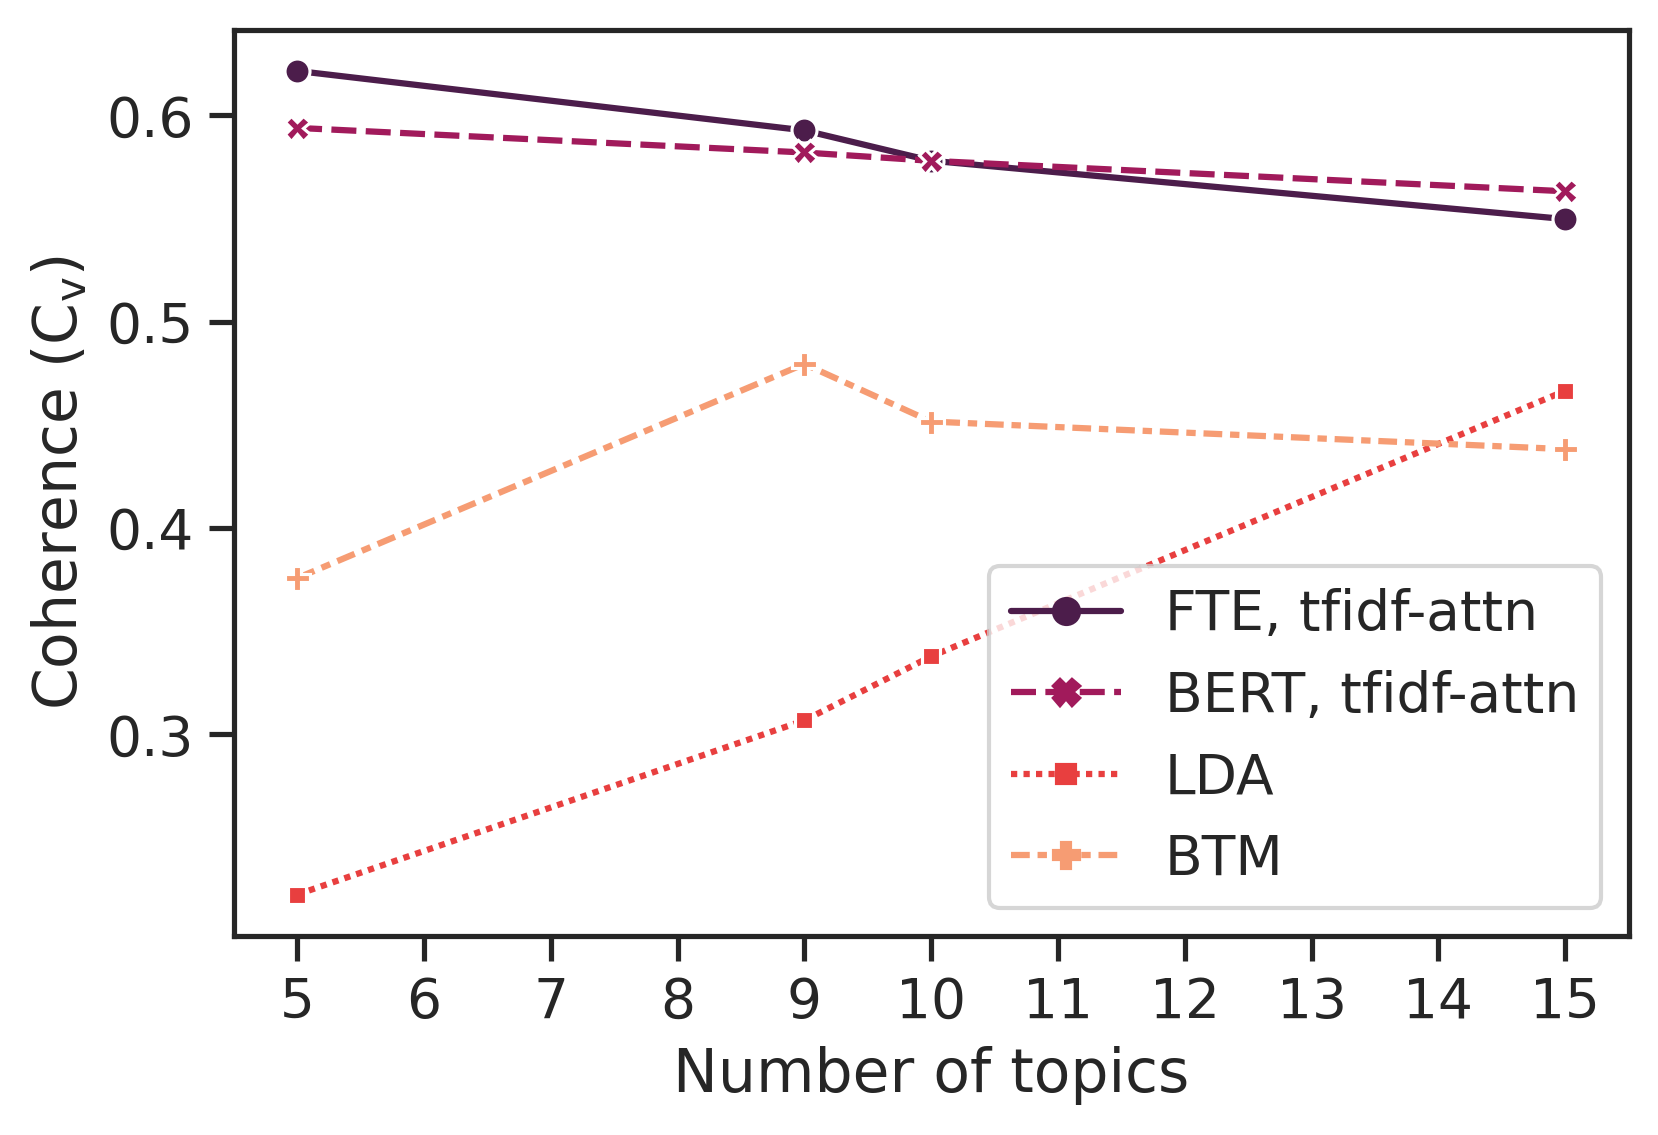

In [ ]:
Image('CV_plot_best_FTA_vs_baselines.png')

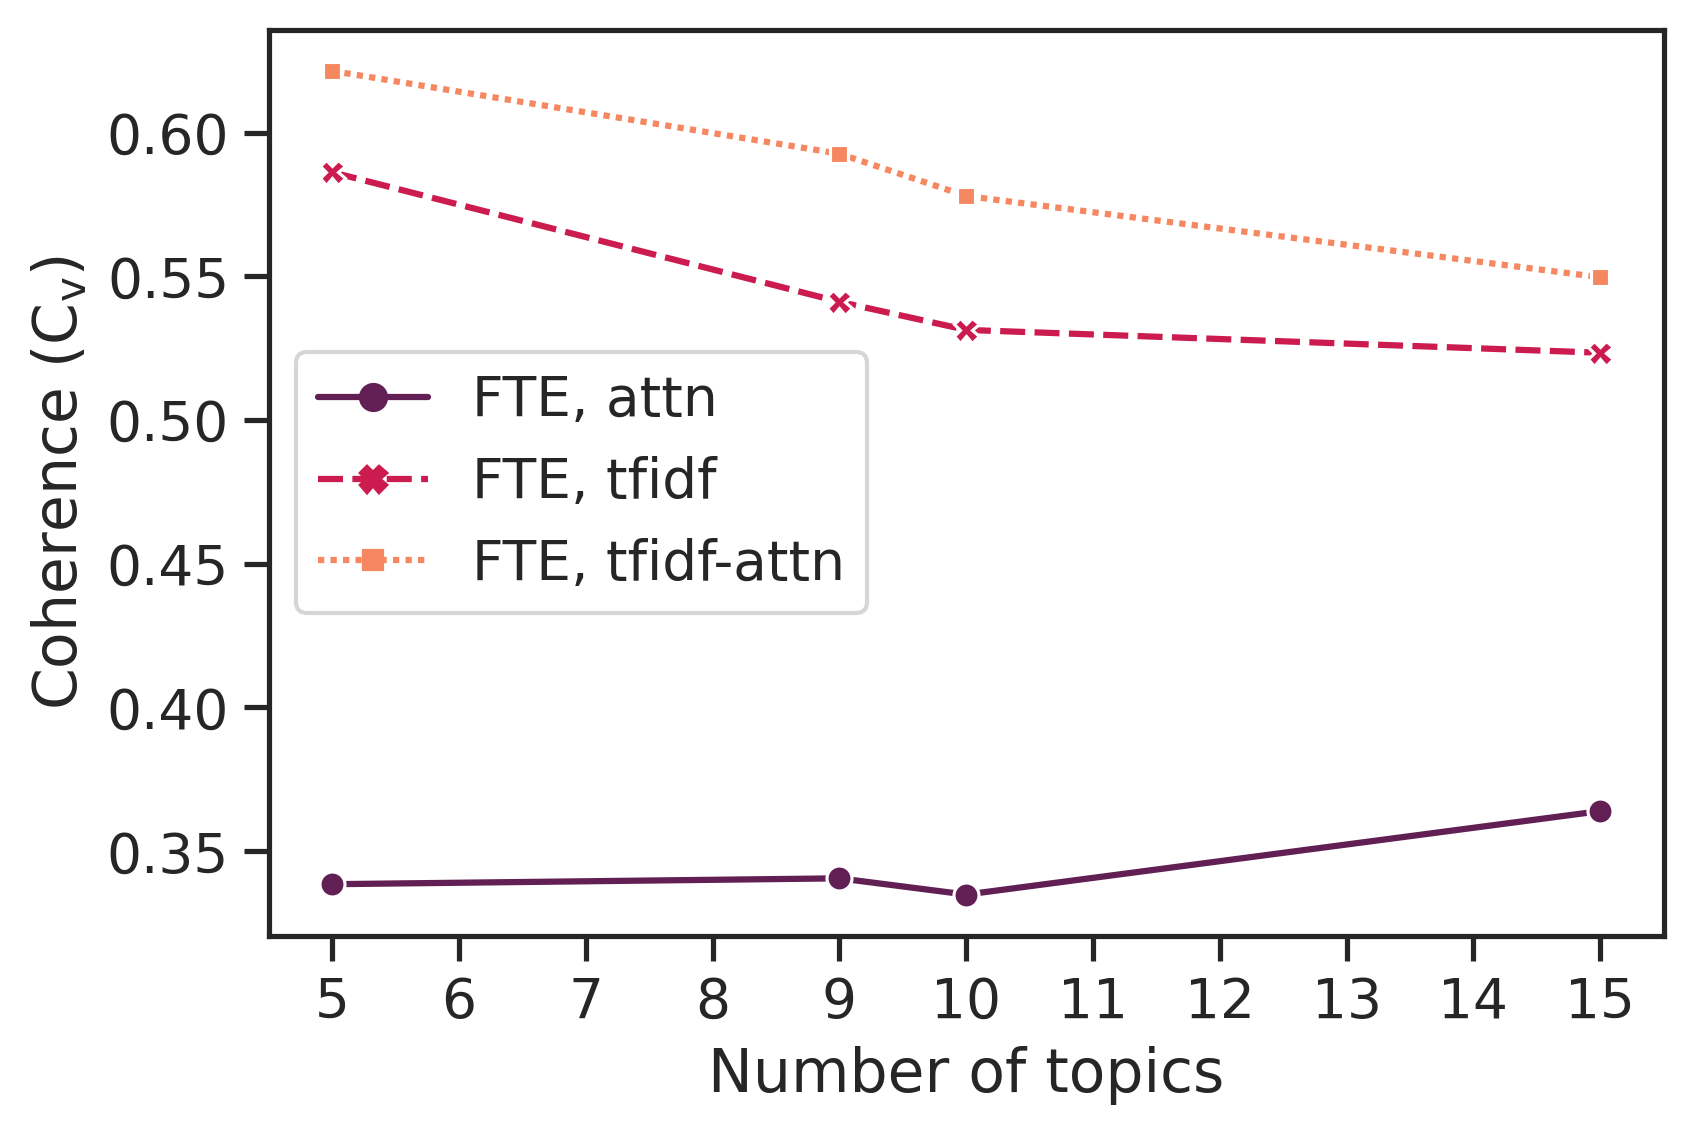

In [ ]:
Image('CV_plot_FTA.png')